###Author
jairobe@google.com

# Description

This demo showcases how a simple processing pipeline can be built to leverage Gemini’s multimodal capabilities in image understanding.  The demo walks through the process of creating a flow whereby images uploaded to a storage bucket are automatically picked up and sent to Gemini for analysis.  This demo can be extended to showcase how the Gemini generated text can be fed into other downstream processes.

### Products
* Google Cloud Storage
* Cloud Run Functions
* Vertex AI Gemini API


##Create Bucket

Navigate to Google Cloud Storage and create bucket.

Feel free to leave all settings as standard for simplicity.

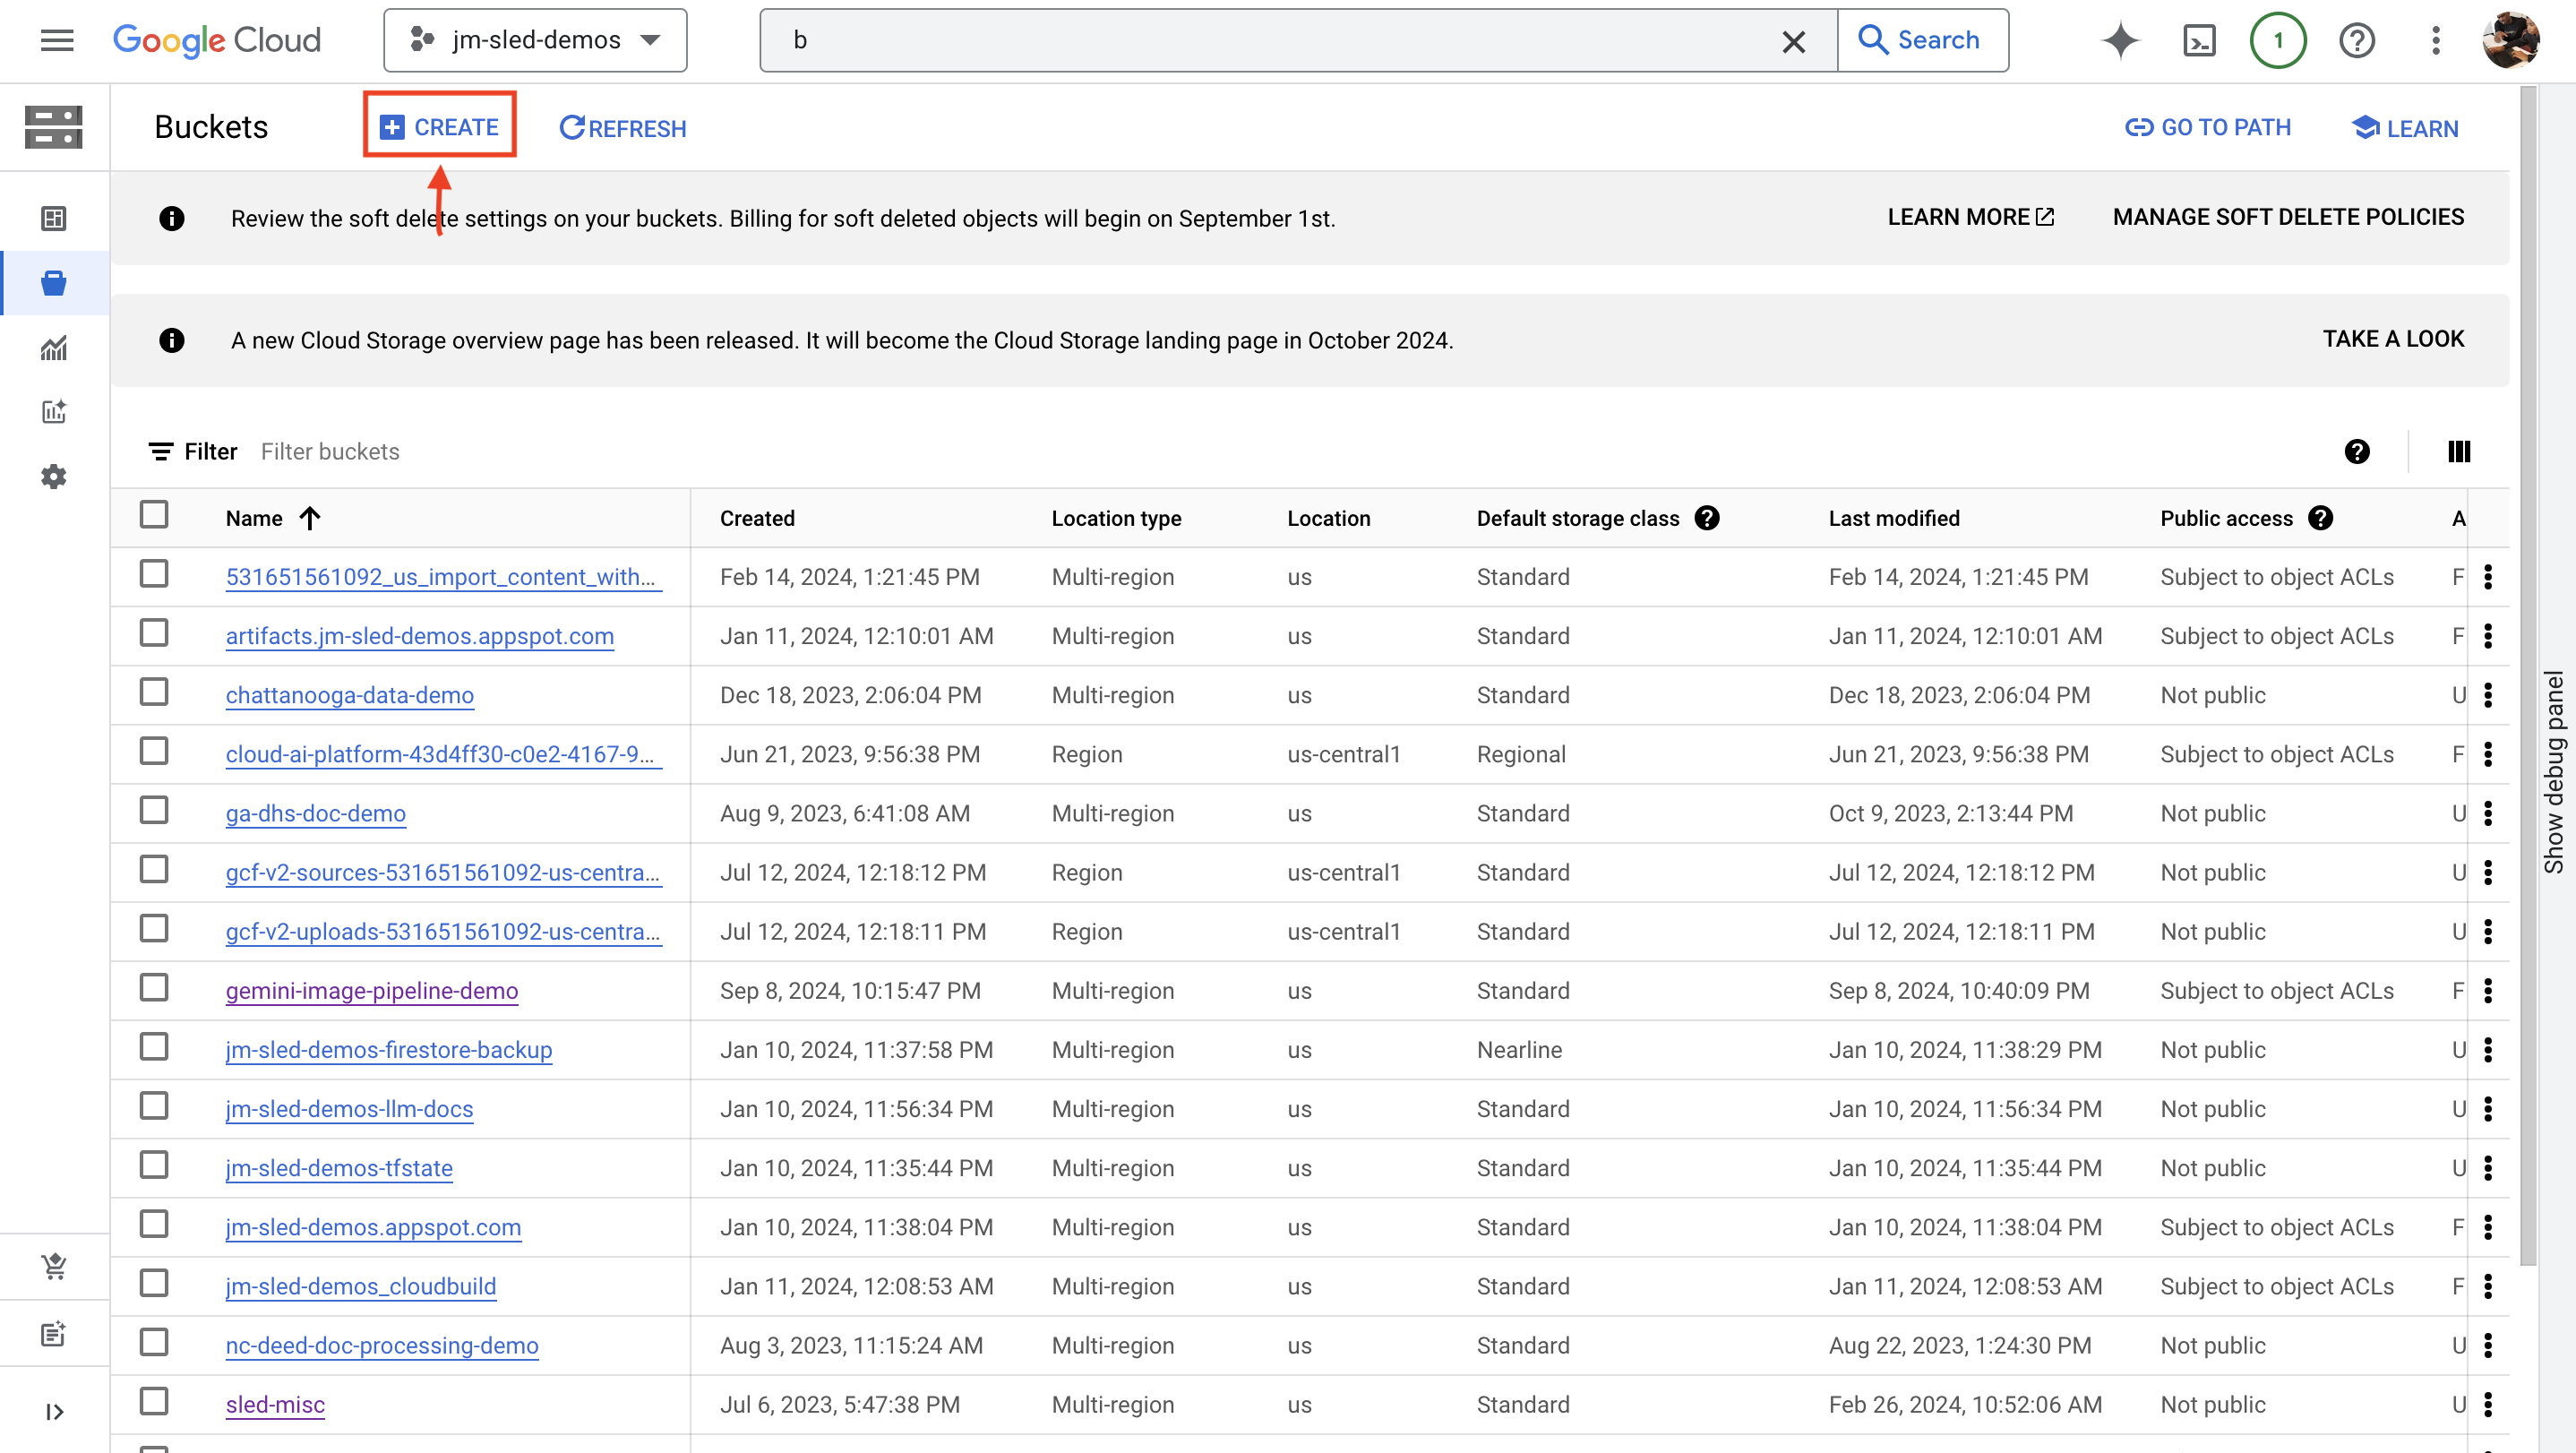

## Create Cloud Run Function
Navigate to Cloud Run Functions and click **Create**


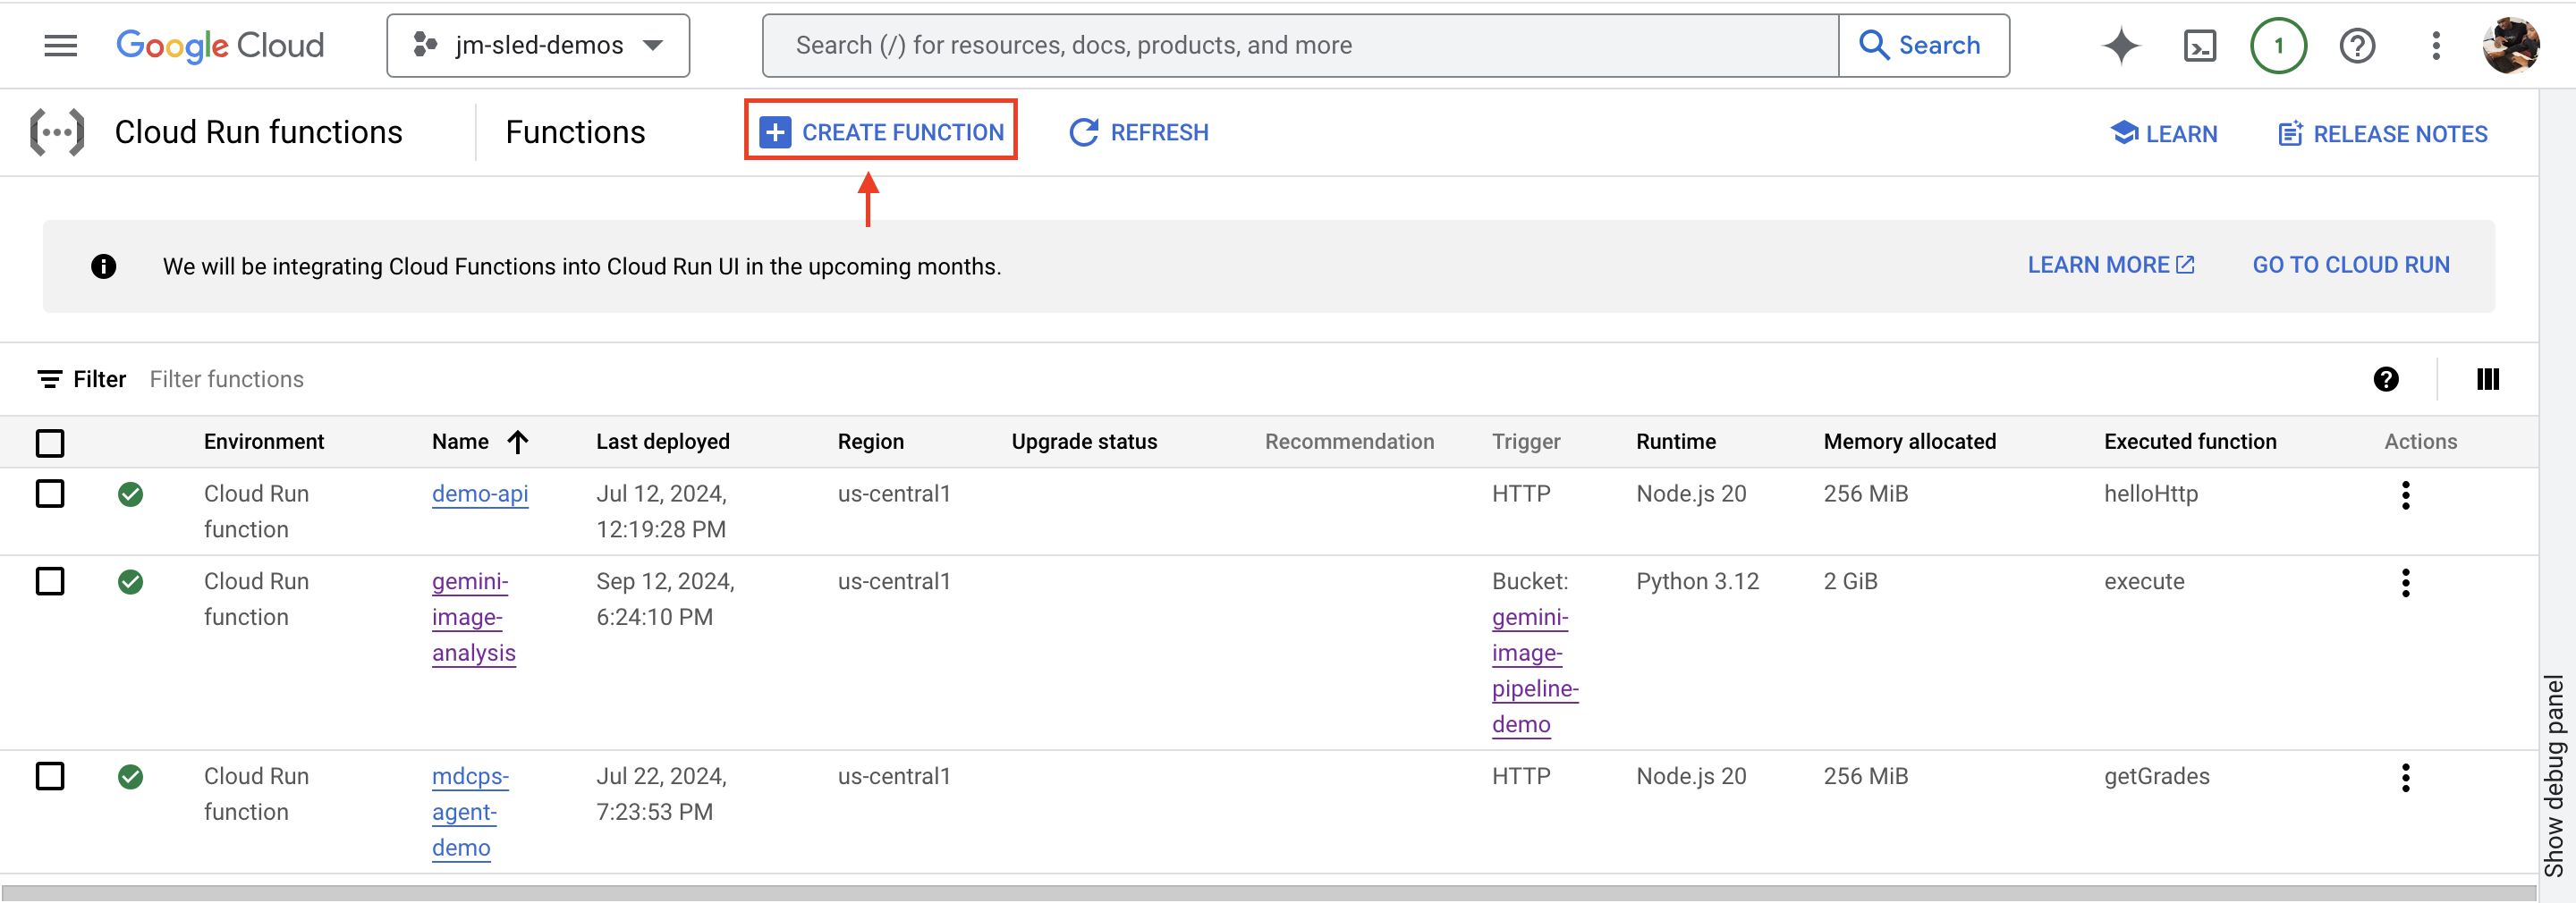

### Select GCS Bucket as Trigger Type
After providing the function name and region, select the trigger type of Cloud Storage from the dropdown list.  

Leave Event Type as Finalized.

Select the Google Cloud Storage bucket created earlier (use the Browse functionality if need be)

Click **Next** when done.

*Note: Ideally you should select your Cloud Run Function region to match the region of your Cloud Storage Bucket*


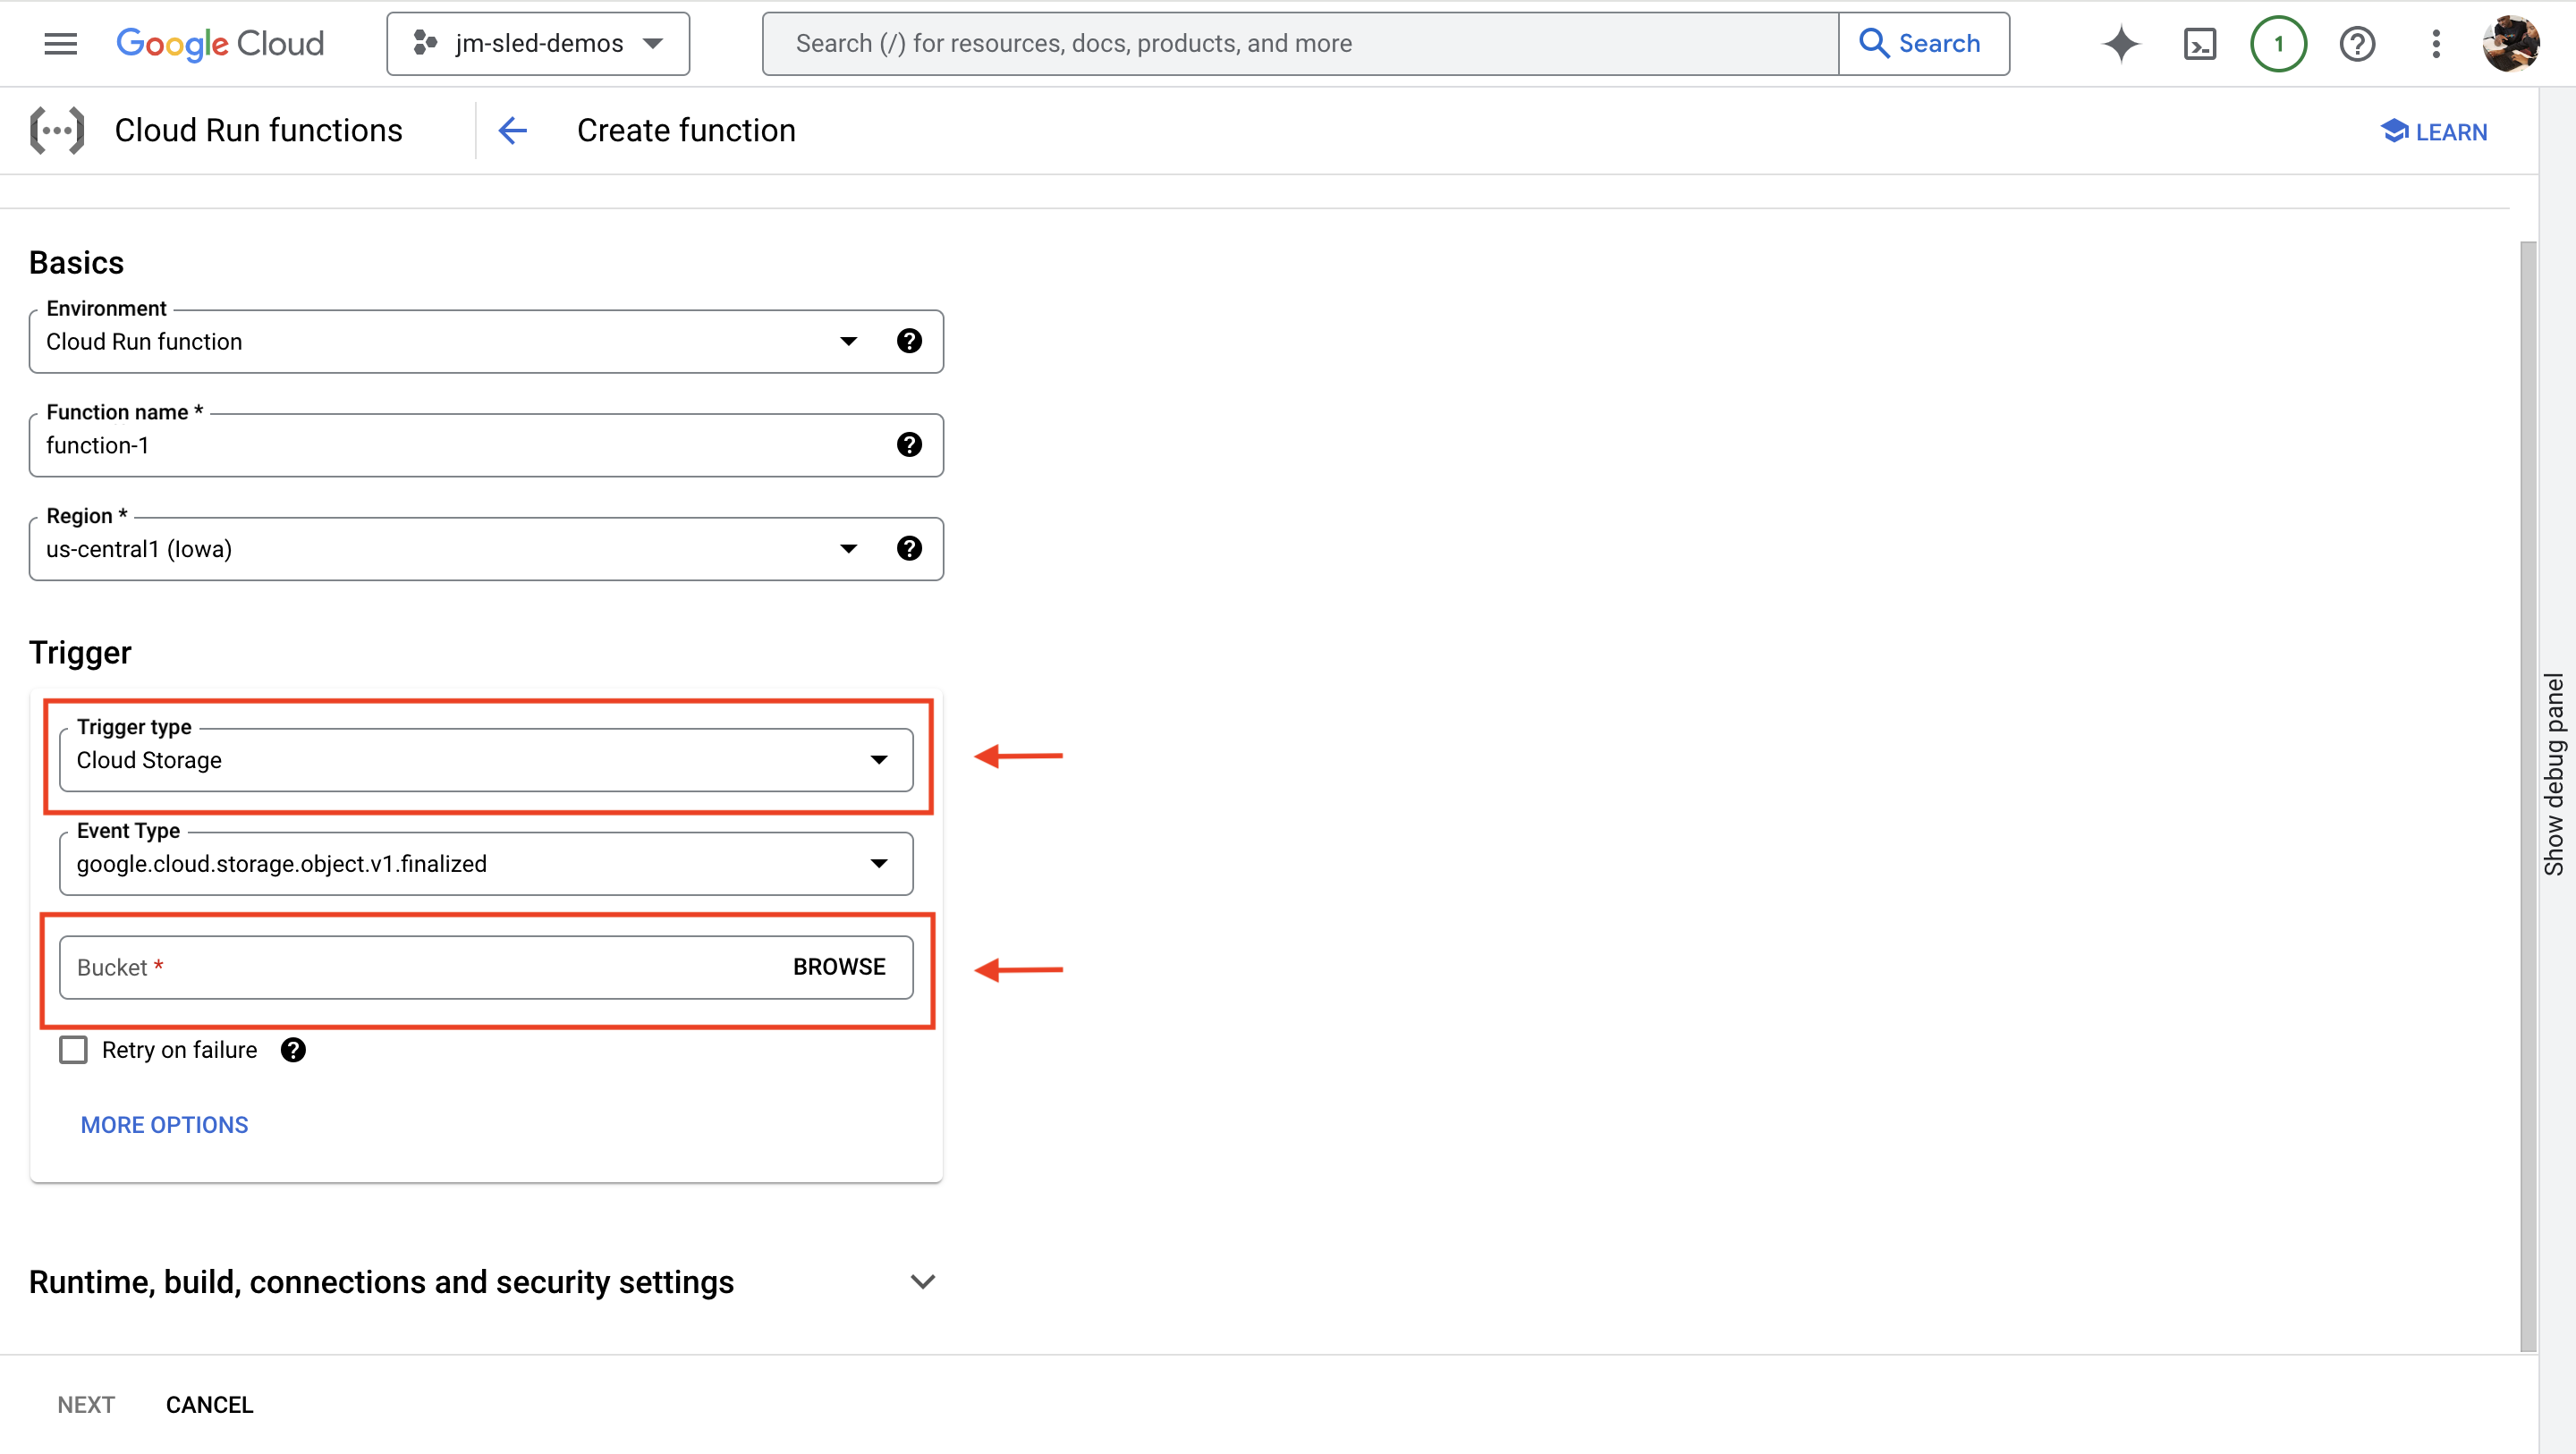

## Update the Code
Update the Runtime to Python 3.12

Copy and paste the code below into the source editor.  Make sure to **replace line 36 and line 74** with your project name/location and prompt respectively.

Edit requirements.txt file to include the following packages:

* google-cloud-aiplatform
* google-cloud-storage

Edit entry point to: execute

Click **Deploy**
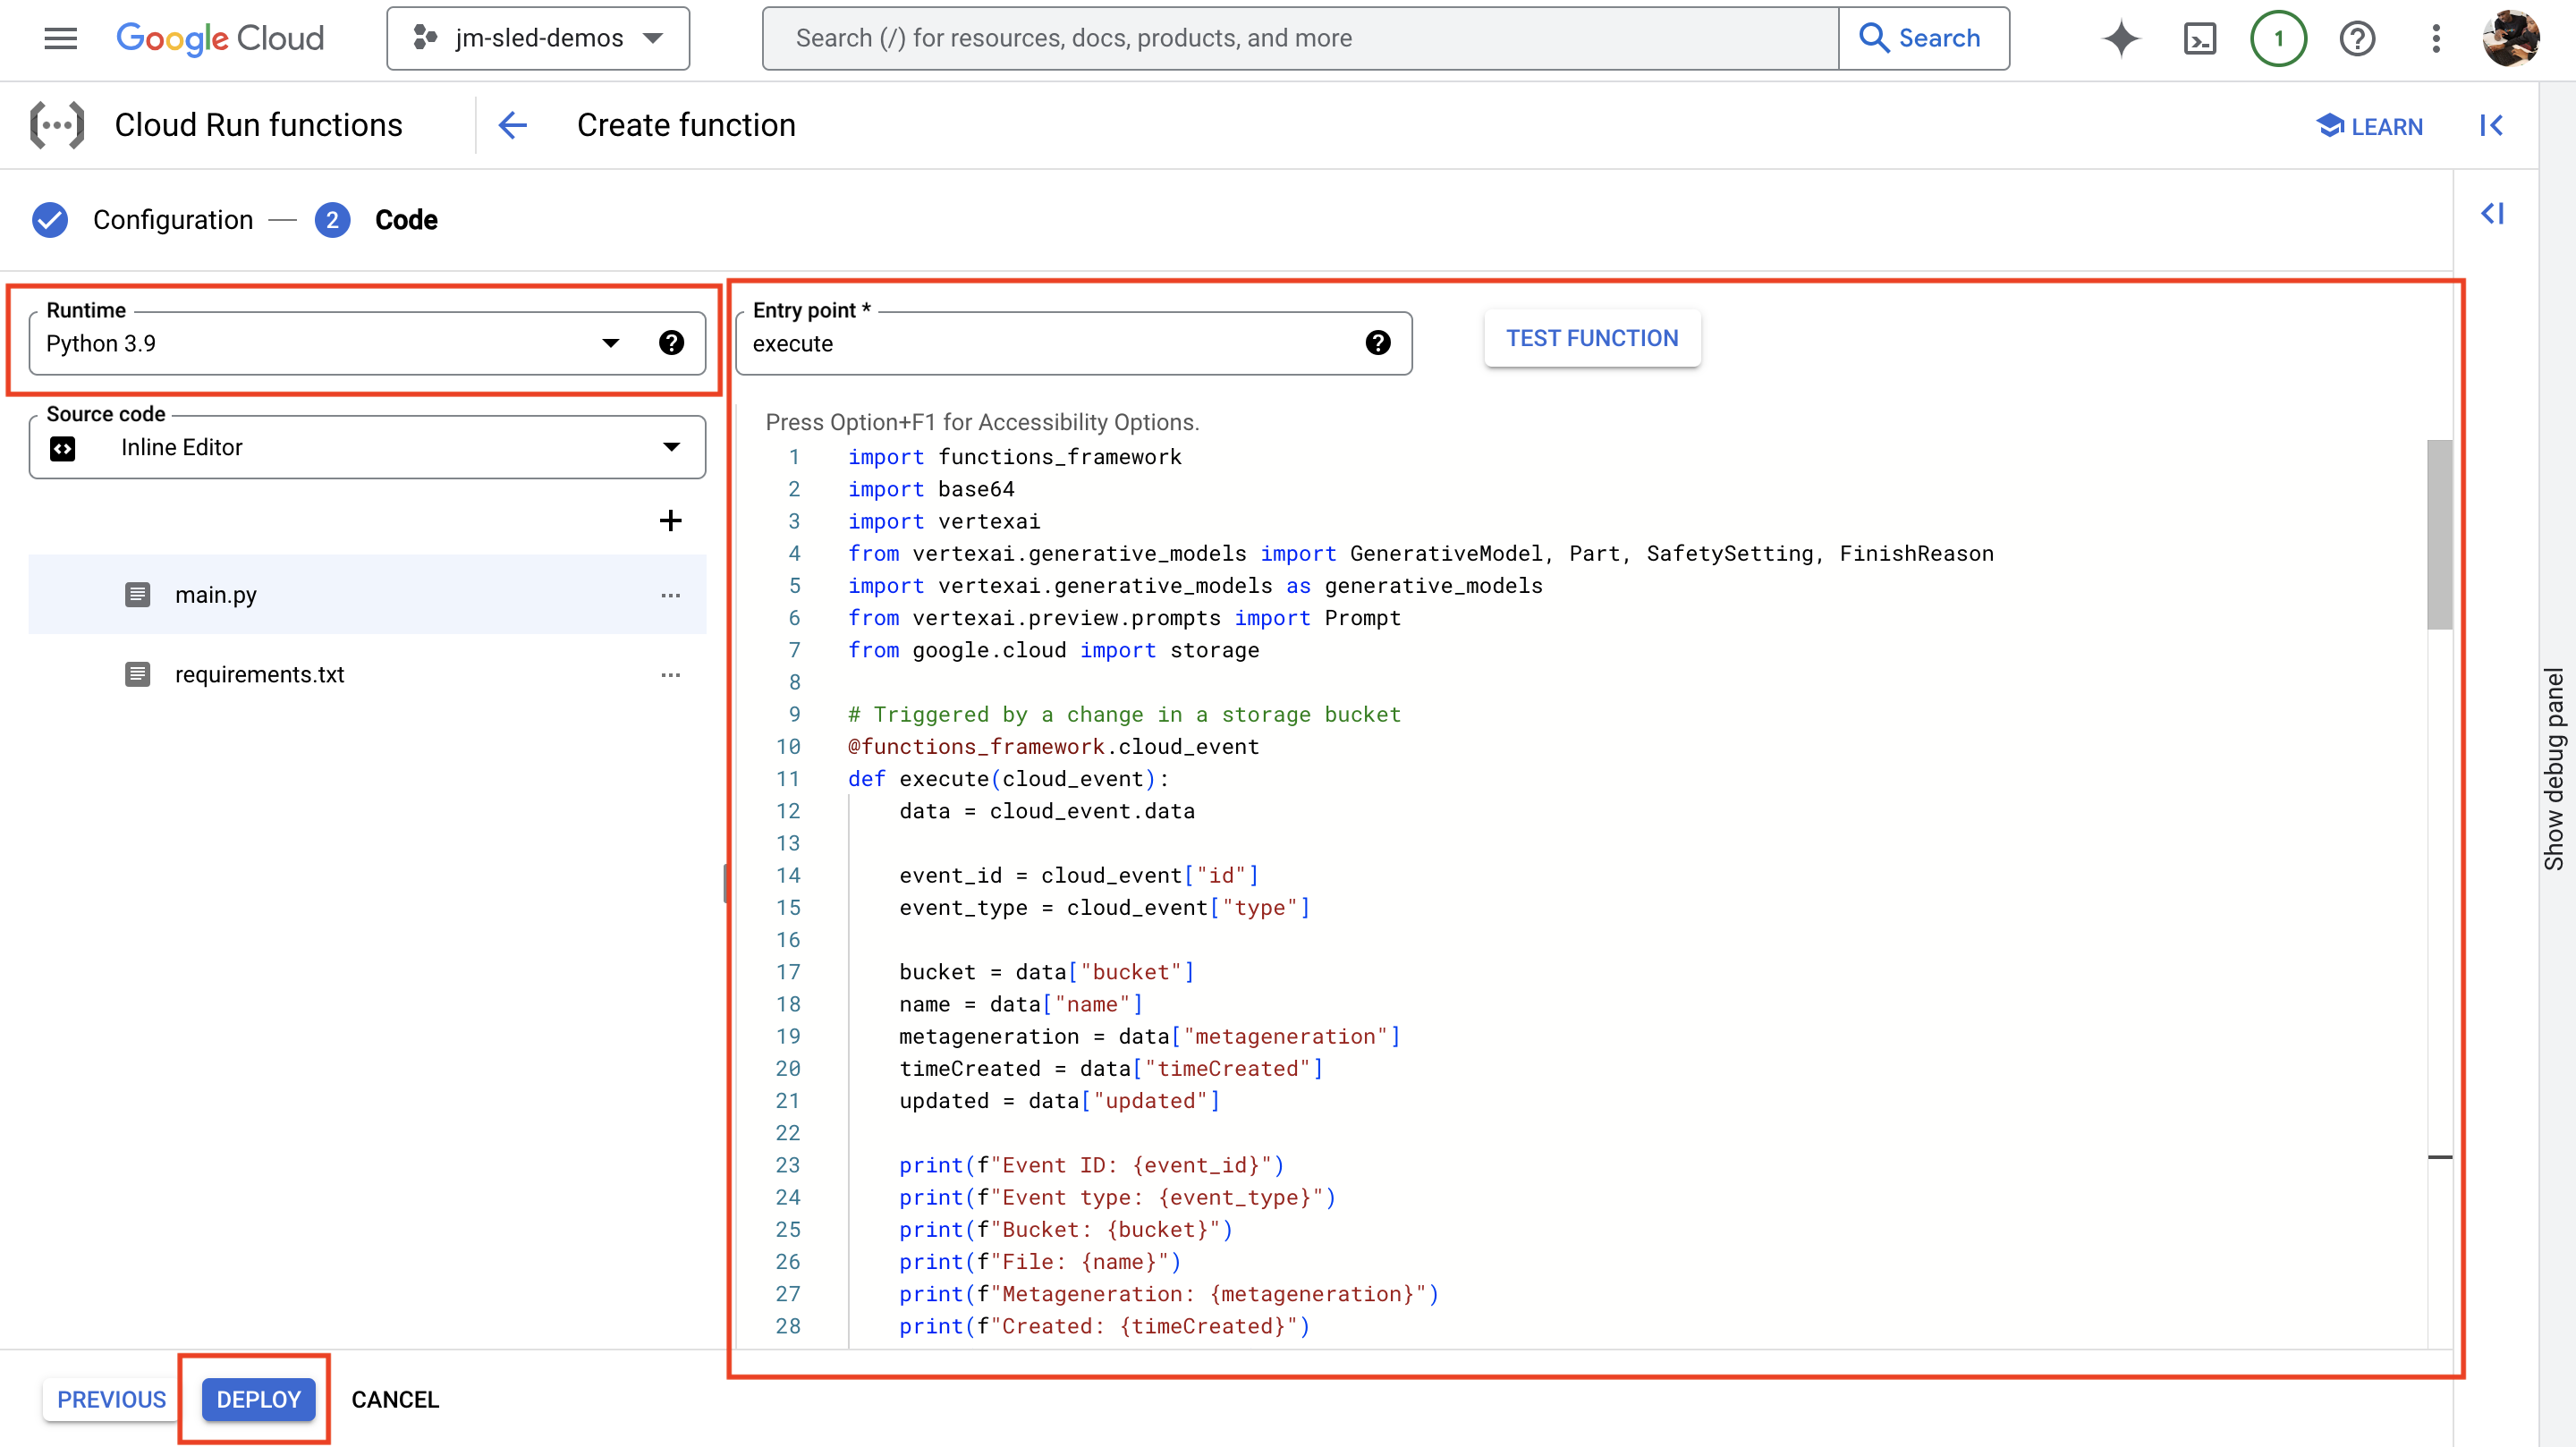

In [ ]:
import functions_framework
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, SafetySetting, FinishReason
import vertexai.generative_models as generative_models
from vertexai.preview.prompts import Prompt
from google.cloud import storage

# Triggered by a change in a storage bucket
@functions_framework.cloud_event
def execute(cloud_event):
    data = cloud_event.data

    event_id = cloud_event["id"]
    event_type = cloud_event["type"]

    bucket = data["bucket"]
    name = data["name"]
    metageneration = data["metageneration"]
    timeCreated = data["timeCreated"]
    updated = data["updated"]

    print(f"Event ID: {event_id}")
    print(f"Event type: {event_type}")
    print(f"Bucket: {bucket}")
    print(f"File: {name}")
    print(f"Metageneration: {metageneration}")
    print(f"Created: {timeCreated}")
    print(f"Updated: {updated}")

    image_data = download_blob_into_memory(bucket,  name)

    generate(image_data)

def generate(byte_data):
    vertexai.init(project="jm-sled-demos", location="us-central1") # Enter your project id here
    image1 = Part.from_data(
    mime_type="image/png",
    data=(byte_data)
    )

    variables = [
    {
    },
    ]

    generation_config = {
        "max_output_tokens": 8192,
        "temperature": 1,
        "top_p": 0.95,
    }

    safety_settings = [
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
            threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
            threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
            threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
            threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
        ),
    ]

    model = GenerativeModel("gemini-1.5-flash-001")
    responses = model.generate_content(
        ["Describe what you see.", image1], # Enter your prompt here
        generation_config=generation_config,
        stream=True,
    )

    for response in responses:
        print(response.text, end="")

def download_blob_into_memory(bucket_name, blob_name):
    """Downloads a blob into memory."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The ID of your GCS object
    # blob_name = "storage-object-name"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(blob_name)
    contents = blob.download_as_bytes()

    print(
        "Downloaded storage object {} from bucket {} as the following bytes object: {}.".format(
            blob_name, bucket_name, contents
        )
    )

    return contents

## Upload Content to Bucket
Navigate back to Google Cloud Storage Bucket.

Upload image to bucket.


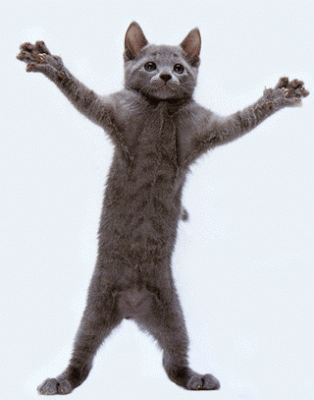

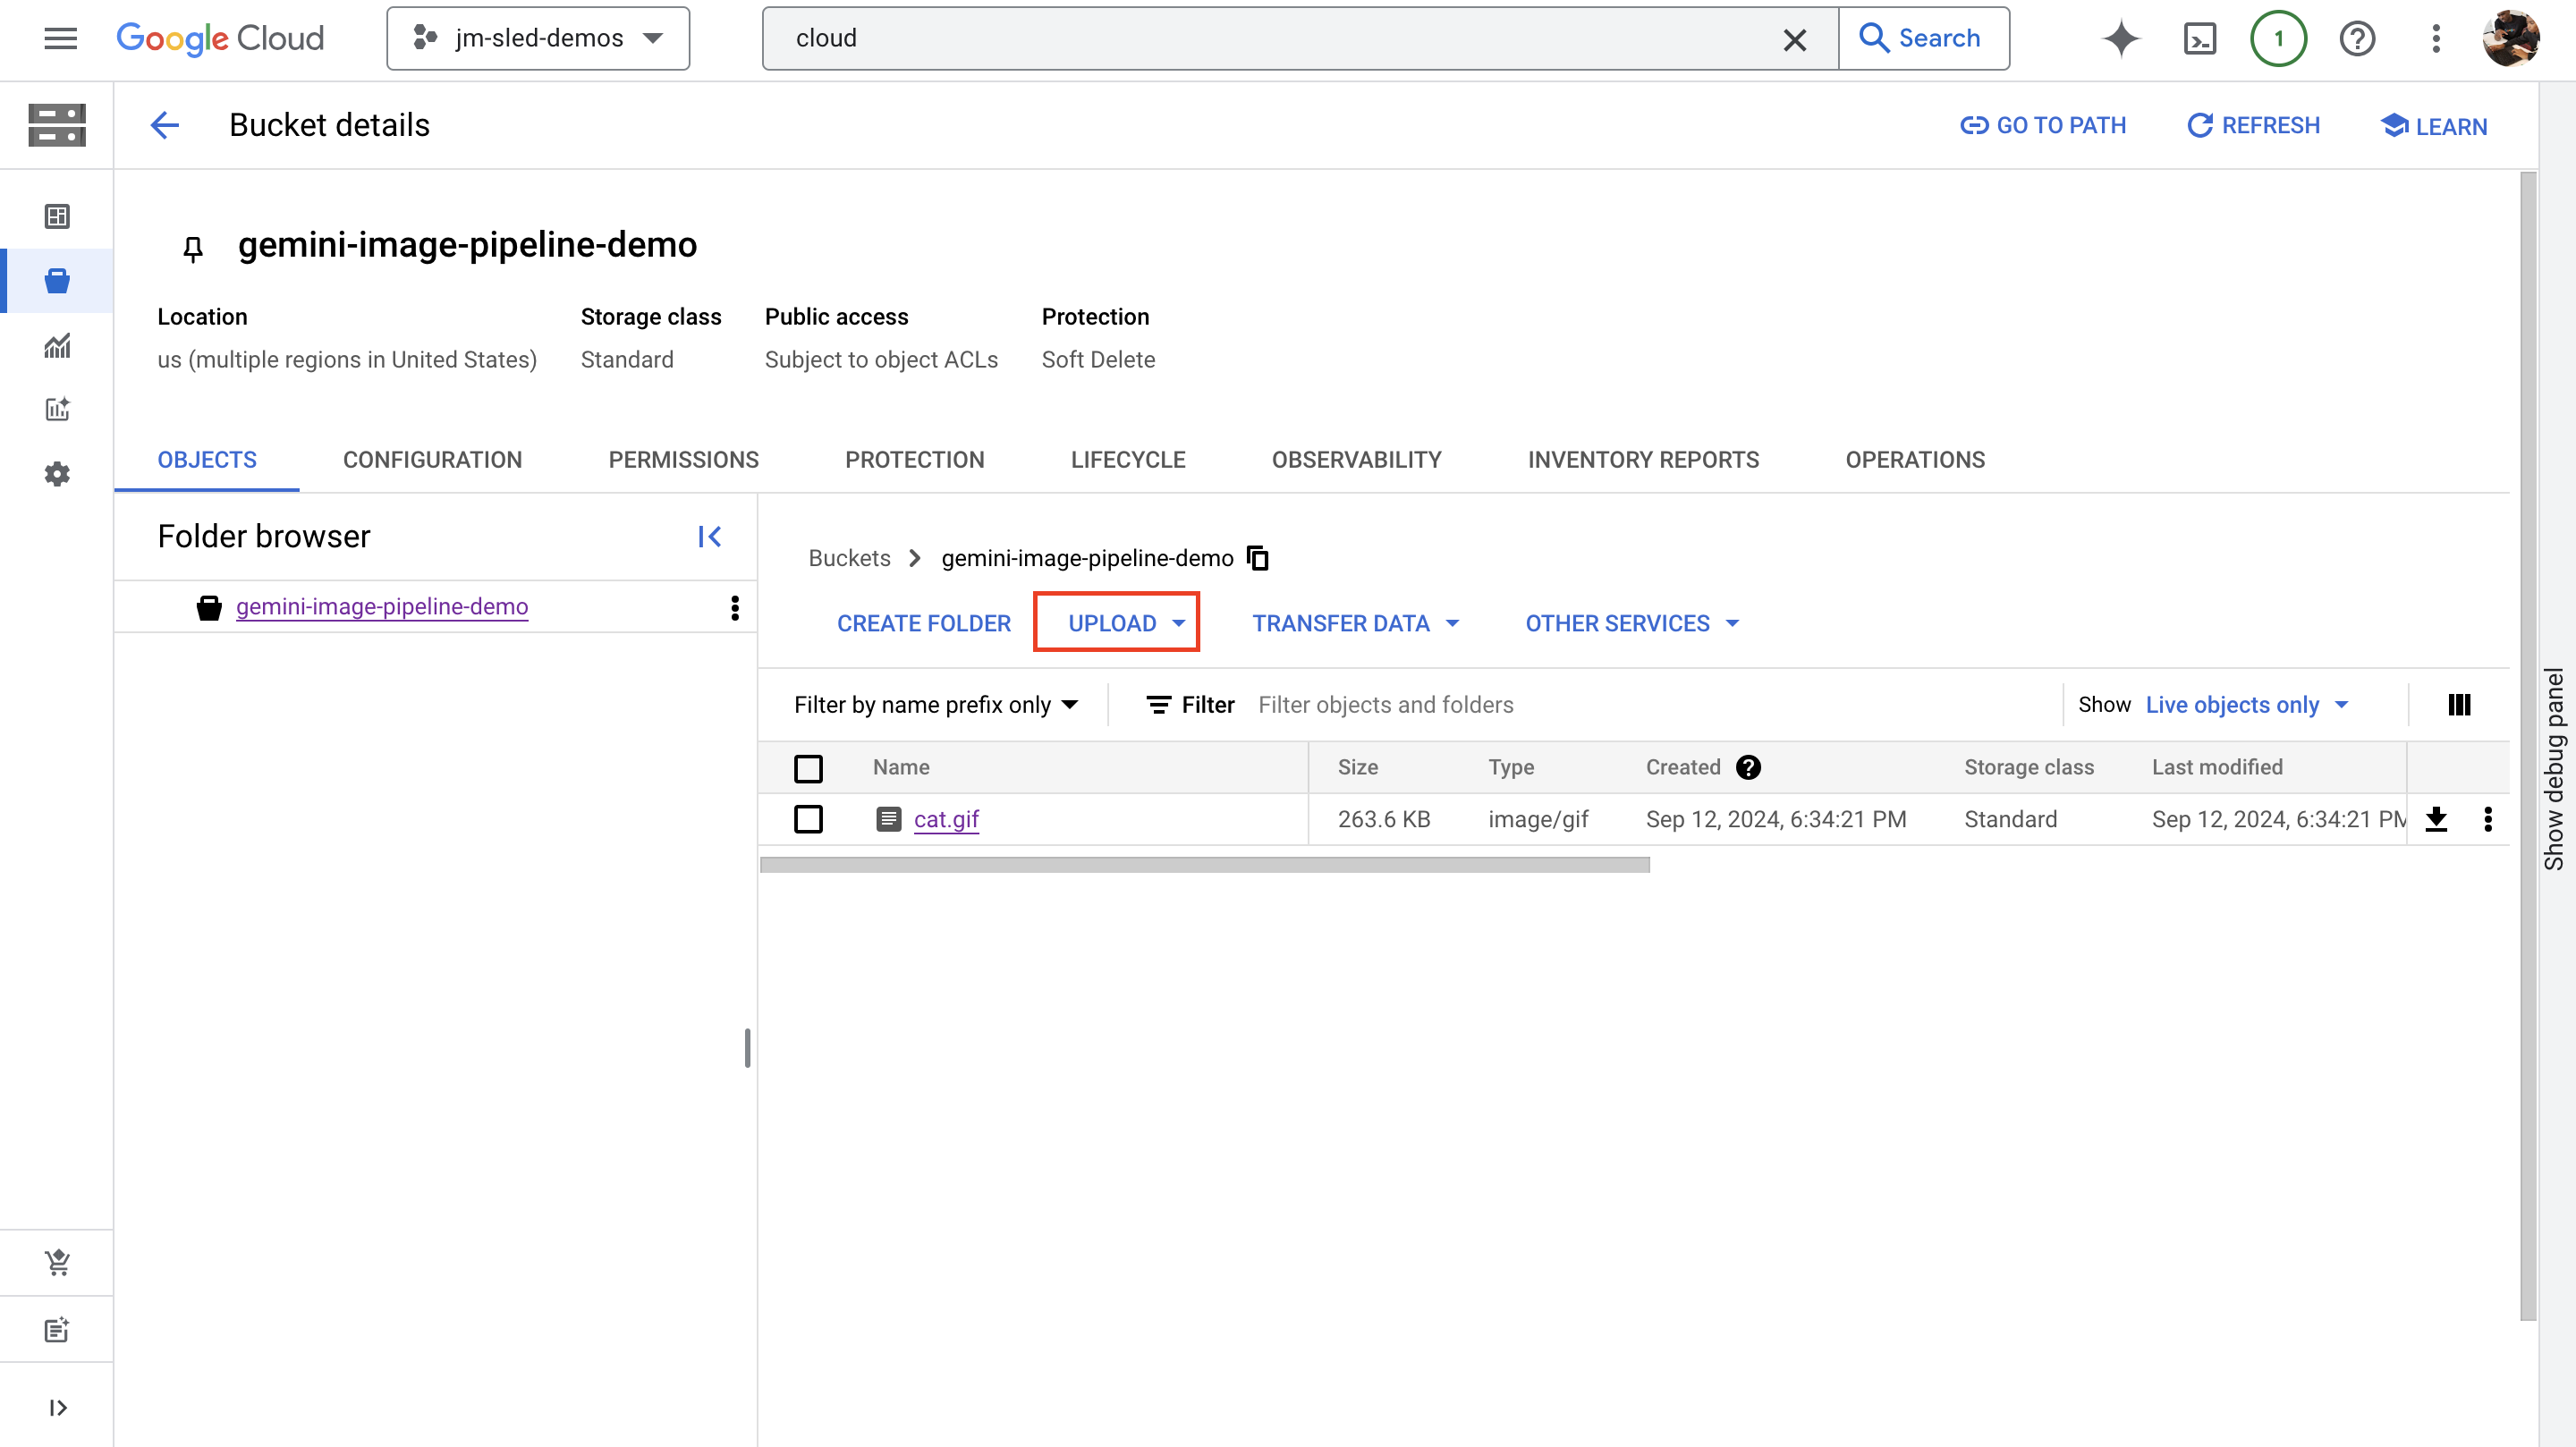

## Evaluate Results
Navigate back to Cloud Run Functions.

Select the function you just deployed.

Navigate to Logs.

**Examine Logs for description of uploaded image(s).**


*Note: For freshly deployed functions you may need to wait a few minutes*


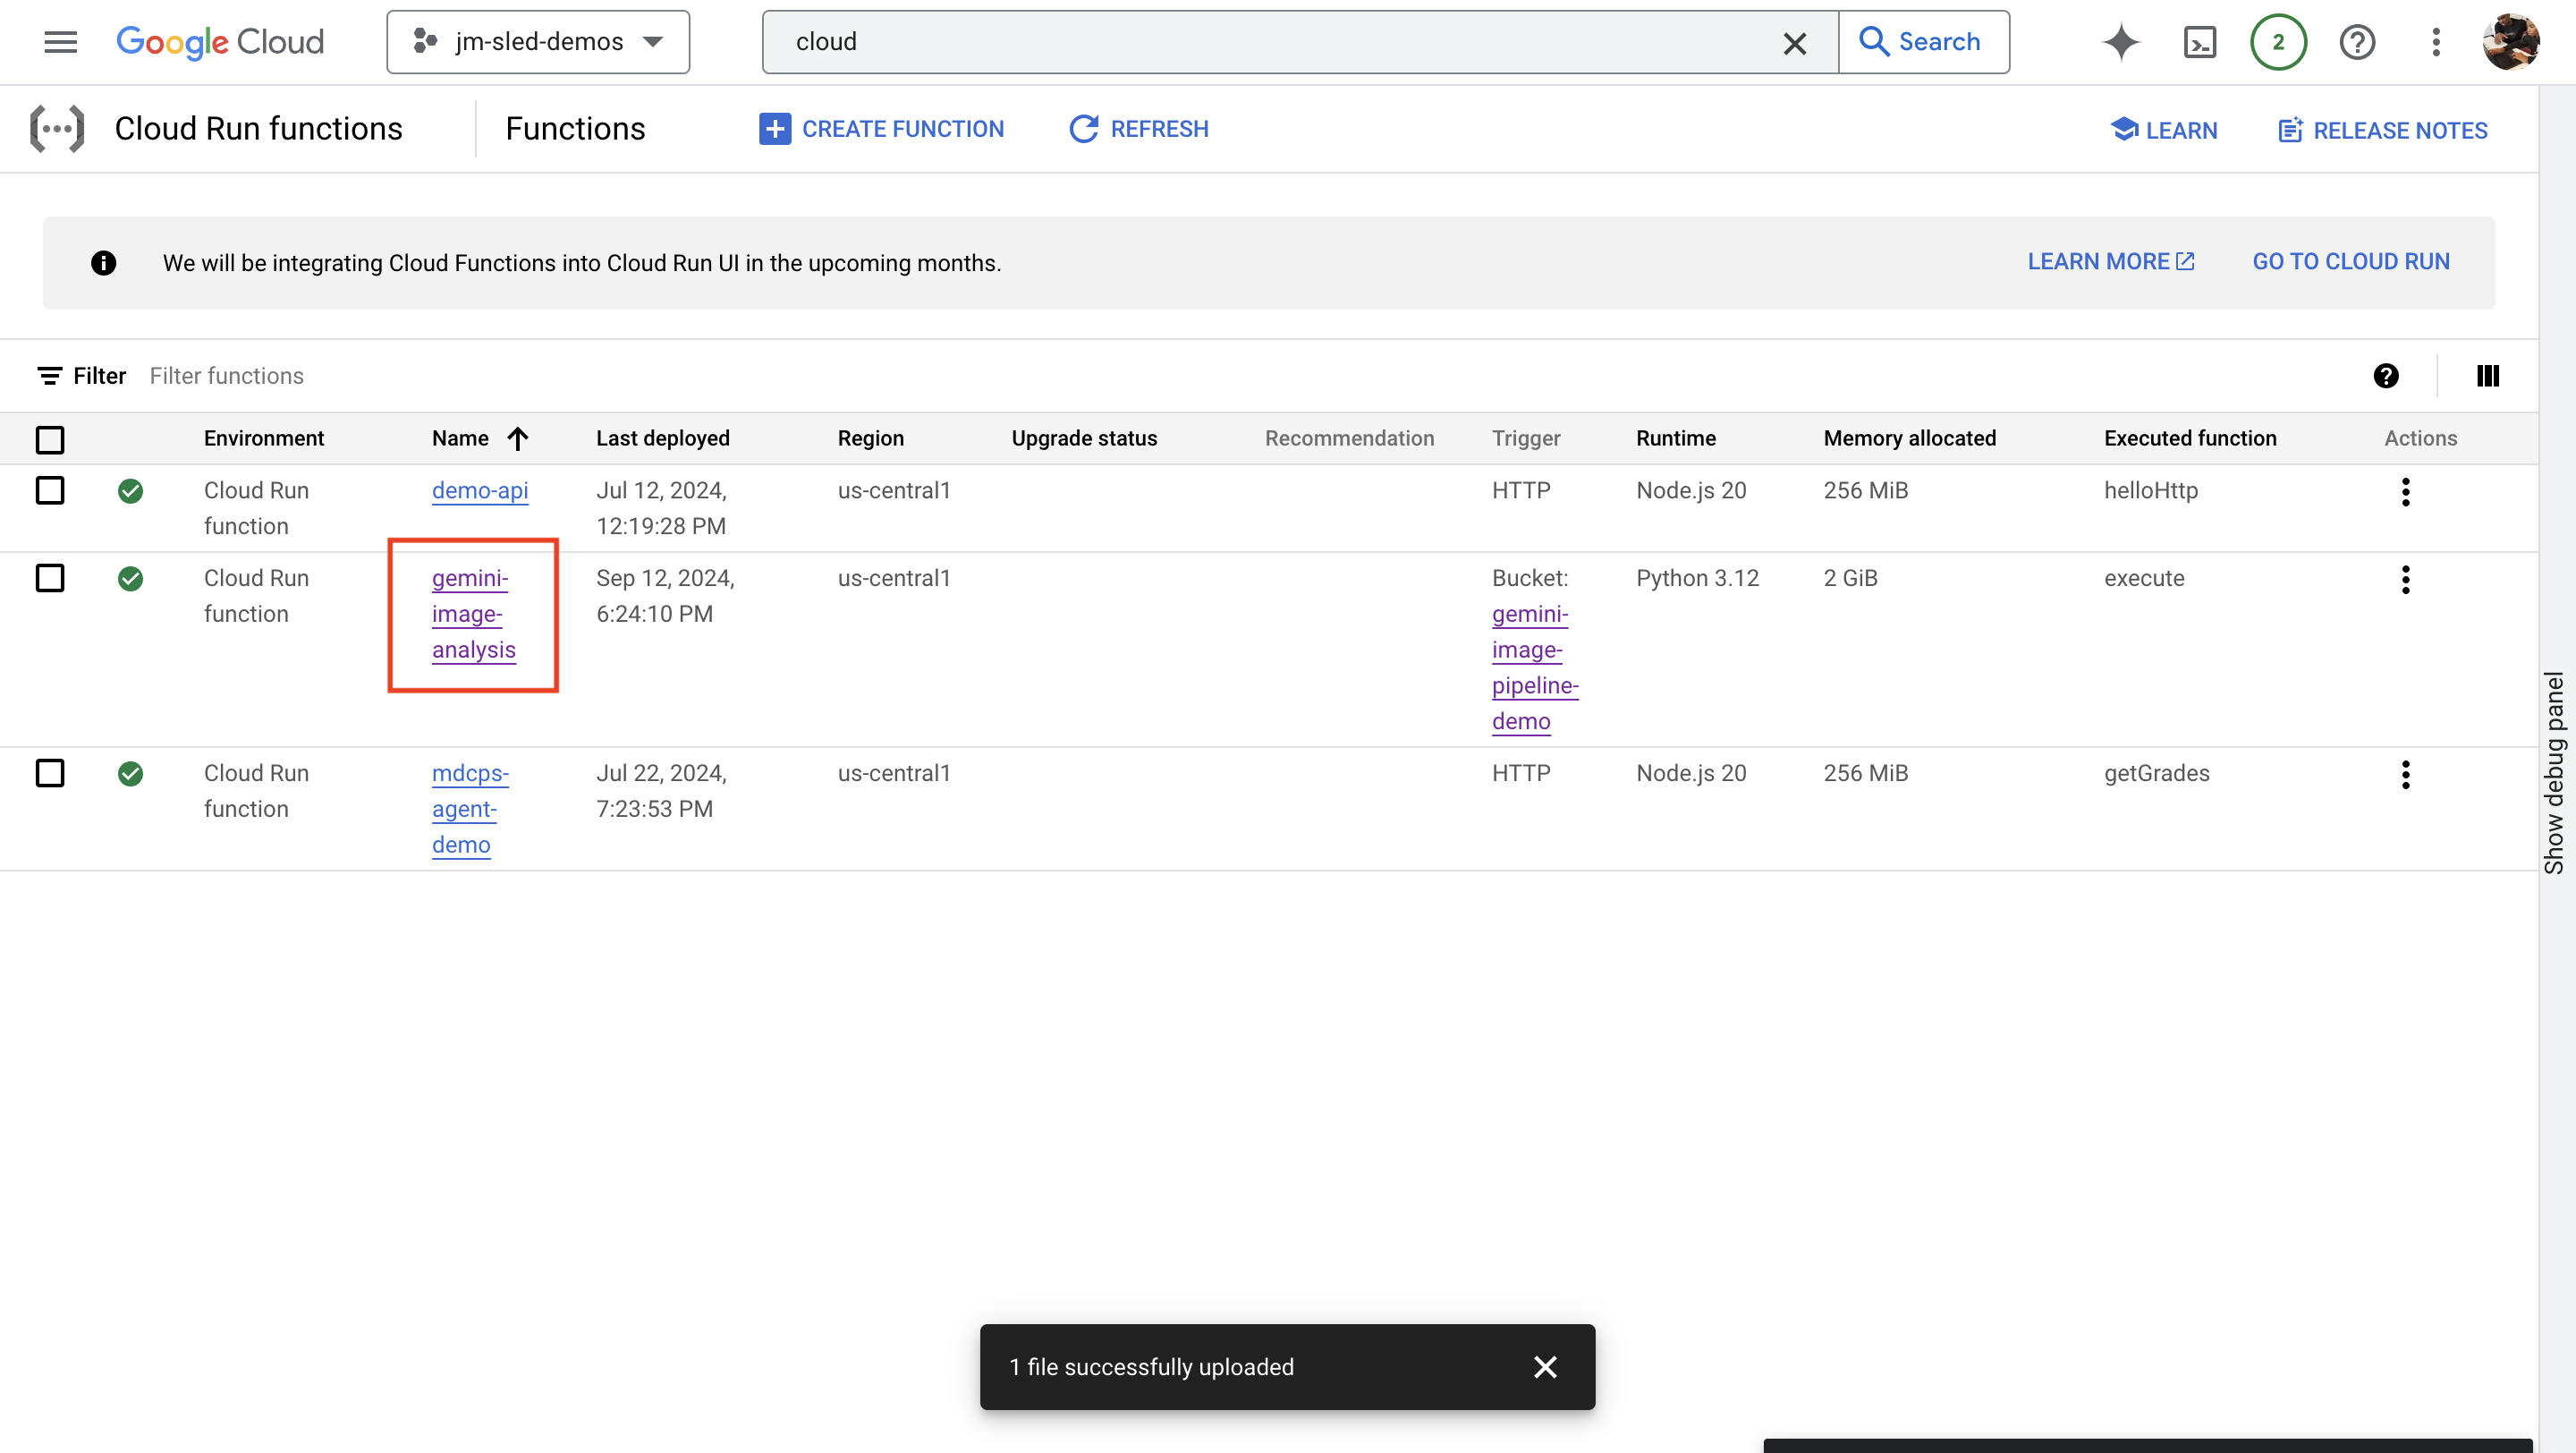

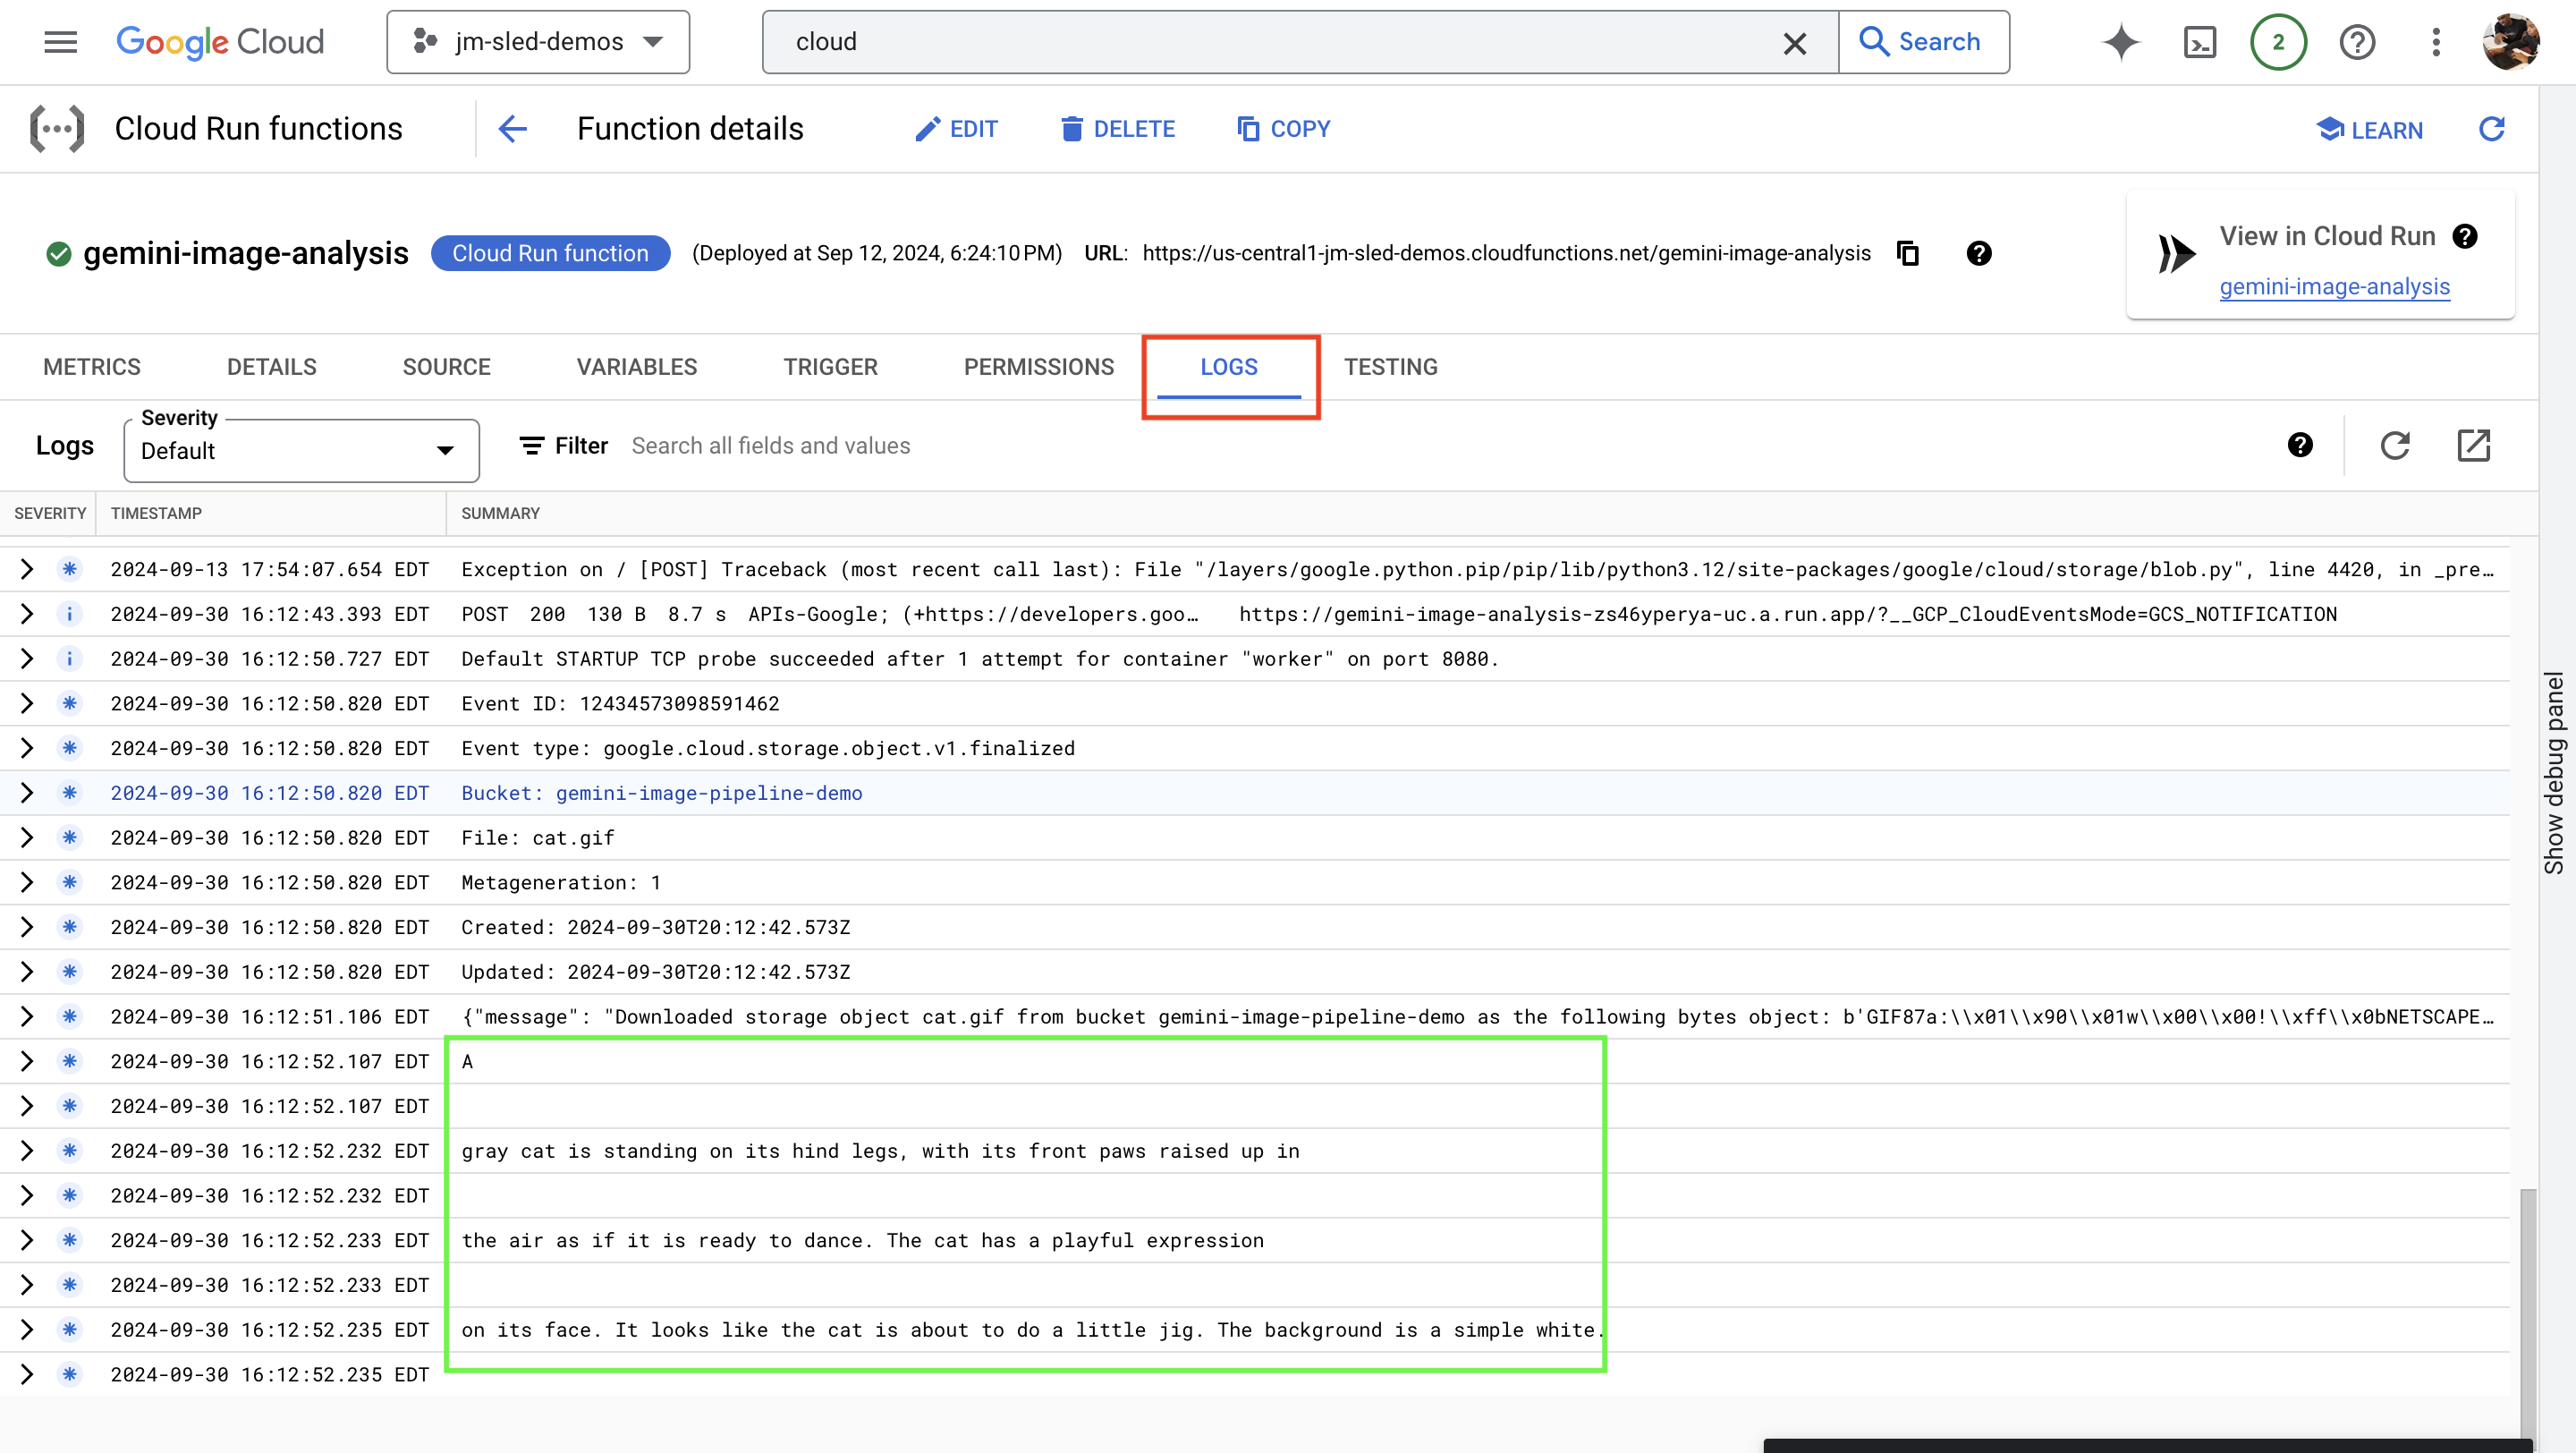